# 4. Market calibration

In this notebook, I will implement an algorith to calibrate the Heston model to market data.

## 4.1. Synthetic data

First, in order to validate the algorithm and the approach, I will generate synthetic data through Monte Carlo simulations. Once the data is generated, I will compare the calibration to the real value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
from scipy.interpolate import griddata
import matplotlib.ticker as ticker

script_path = os.path.abspath(os.path.join("..", "Scripts"))
if script_path not in sys.path:
    sys.path.append(script_path)

import Heston

## 4. 1. 1. Theroetical market

In [2]:
# Market state
S0 = 100
r = 0.02
v0 = 0.15
kappa = 1.5
theta = 0.06
sigma = 0.4
rho = -0.4

T_grid = np.linspace(0.05, 1.0, 20)
K_grid = np.linspace(0.7 * S0, 1.5 * S0, 9)

data = []

for T in T_grid:
    _, prices = Heston.heston_fft_prices(S=S0, T=T, kappa=kappa, rho=rho, sigma=sigma,theta=theta, v0=v0*v0, rate=r, div=0, strikes=K_grid)
    for K, price in zip(K_grid, prices):
        data.append({'T': T, 'K': K, 'Price': price})

df_FFT = pd.DataFrame(data)
df_FFT.tail()

,T,K,Price
175,1.0,110.0,5.384366
176,1.0,120.0,2.756809
177,1.0,130.0,1.290443
178,1.0,140.0,0.621641
179,1.0,150.0,0.323269


In [3]:
def calibrate_heston(market_df, S0, r, q=0):
    from scipy.optimize import minimize
    
    def loss_function(params):
        kappa, rho, sigma, theta, v0 = params
        error_sum = 0.0
        
        for T, group in market_df.groupby('T'):
            strikes = group['K'].values
            market_prices = group['Price'].values
            
            _, model_prices = Heston.heston_fft_prices(  S0, T, kappa, rho, sigma, theta, v0, r, q, strikes )
            error_sum += np.mean(np.abs(model_prices - market_prices))
        
        return error_sum

    # Bounds para evitar parámetros imposibles
    bounds = [
        (0.01, 5.0),    # kappa
        (-0.999, 0.999),# rho
        (0.01, 2.0),    # sigma (volvol)
        (0.01, 1.0),    # theta (var de largo plazo)
        (0.01, 1.0)     # v0 (var inicial)
    ]

    initial_guess = [1.0, -0.5, 0.3, 0.05, 0.05]

    result = minimize( loss_function, initial_guess, bounds=bounds, method='L-BFGS-B')
    return result

resultados  = calibrate_heston(df_FFT, S0, r, q=0)
kappa, rho, sigma, theta, v0 = resultados.x
print(kappa, rho, sigma, theta, v0)

1.5000104500664488 -0.40000071595253917 0.40000214612237106 0.060000024649098684 0.02249998745307538


In [4]:
df_FFT["price_model"] = df_FFT.apply(
    lambda row: Heston.heston_fft_prices(S=S0, T=row["T"], kappa=kappa, rho=rho,
        sigma=sigma,  theta=theta, v0=v0, rate=r, strikes=[row["K"]]  )[1][0],   axis=1)
K_vals = df_FFT["K"].values
T_vals = df_FFT["T"].values
Price_model_vals = df_FFT["price_model"].values

K_grid = np.linspace(K_vals.min(), K_vals.max(), 50) 
T_grid = np.linspace(T_vals.min(), T_vals.max(), 50)
K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

Price_model_grid = griddata( (K_vals, T_vals), Price_model_vals,  (K_mesh, T_mesh),   method='cubic')

fig = go.Figure()

fig.add_trace(go.Scatter3d(x=K_vals, y=T_vals, z=df_FFT["Price"].values,mode='markers',
                           marker=dict(size=5, color='red', opacity=1.0),name='Market Prices'))
fig.add_trace(go.Surface(x=K_mesh, y=T_mesh, z=Price_model_grid,colorscale='viridis',
                         opacity=0.7,name='Heston Model Prices'))
fig.update_layout(scene=dict(xaxis_title='Strike (K)', yaxis_title='Maturity (T)', zaxis_title='Option Price'),
    template="plotly_white")

fig.show(renderer="colab")

## 4.1. 2. Monte Carlo synthetic data

In [5]:
# Market state
S0 = 100
r = 0.02
v0 = 0.15
kappa = 1.5
theta = 0.06
sigma = 0.4
rho = -0.4

T_grid = np.linspace(0.05, 1.0, 20)
K_grid = np.linspace(0.7 * S0, 1.5 * S0, 9)

M = 500000     # número de simulaciones
N_steps = 1000  # pasos por simulación

T_max = T_grid[-1]
precios, _ = Heston.simular_en_paralelo(M, S0, v0, r, kappa, theta, sigma, rho, T_max, N_steps)

time_indices = (T_grid / T_max * N_steps).astype(int)


data = []

for i, T in enumerate(T_grid):
    idx = time_indices[i]
    ST = precios[:, idx]
    
    for K in K_grid:
        payoff = np.maximum(ST - K, 0)
        price = np.exp(-r * T) * np.mean(payoff)
        data.append({'T': T, 'K': K, 'Price': price})

df = pd.DataFrame(data)

In [6]:
def calibrate_heston(market_df, S0, r, q=0):
    from scipy.optimize import minimize
    
    def loss_function(params):
        kappa, rho, sigma, theta, v0 = params
        error_sum = 0.0
        
        for T, group in market_df.groupby('T'):
            strikes = group['K'].values
            market_prices = group['Price'].values
            
            _, model_prices = Heston.heston_fft_prices(  S0, T, kappa, rho, sigma, theta, v0, r, q, strikes )
            error_sum += np.mean(np.abs(model_prices - market_prices))
        
        return error_sum

    # Bounds para evitar parámetros imposibles
    bounds = [
        (0.01, 5.0),    # kappa
        (-0.999, 0.999),# rho
        (0.01, 2.0),    # sigma (volvol)
        (0.01, 1.0),    # theta (var de largo plazo)
        (0.01, 1.0)     # v0 (var inicial)
    ]

    initial_guess = [1.0, -0.5, 0.3, 0.05, 0.03]

    result = minimize( loss_function, initial_guess, bounds=bounds, method='L-BFGS-B'  )
    return result

resultados  = calibrate_heston(df, S0, r, q=0)
kappa, rho, sigma, theta, v0 = resultados.x
print(kappa, rho, sigma, theta, v0)

2.758190048709941 0.4074176251000173 0.015157692803173283 0.03328135134040769 0.01


In [7]:
df["price_model"] = df.apply(
    lambda row: Heston.heston_fft_prices(S=S0, T=row["T"], kappa=kappa, rho=rho,
        sigma=sigma,  theta=theta, v0=v0, rate=r, strikes=[row["K"]]  )[1][0],   axis=1)
df.tail()

,T,K,Price,price_model
175,1.0,110.0,4.251251,4.045719
176,1.0,120.0,1.878512,1.896860
177,1.0,130.0,0.787616,0.773324
178,1.0,140.0,0.330034,0.310457
179,1.0,150.0,0.141615,0.137256


In [8]:
K_vals = df["K"].values
T_vals = df["T"].values
Price_model_vals = df["price_model"].values

K_grid = np.linspace(K_vals.min(), K_vals.max(), 50) 
T_grid = np.linspace(T_vals.min(), T_vals.max(), 50)
K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

Price_model_grid = griddata( (K_vals, T_vals), Price_model_vals,  (K_mesh, T_mesh),   method='cubic')

fig = go.Figure()

fig.add_trace(go.Scatter3d(x=K_vals, y=T_vals, z=df["Price"].values,mode='markers',
                           marker=dict(size=5, color='red', opacity=1.0),name='Market Prices'))
fig.add_trace(go.Surface(x=K_mesh, y=T_mesh, z=Price_model_grid,colorscale='viridis',
                         opacity=0.7,name='Heston Model Prices'))
fig.update_layout(scene=dict(xaxis_title='Strike (K)', yaxis_title='Maturity (T)', zaxis_title='Option Price'),
    template="plotly_white")

fig.show(renderer="colab")

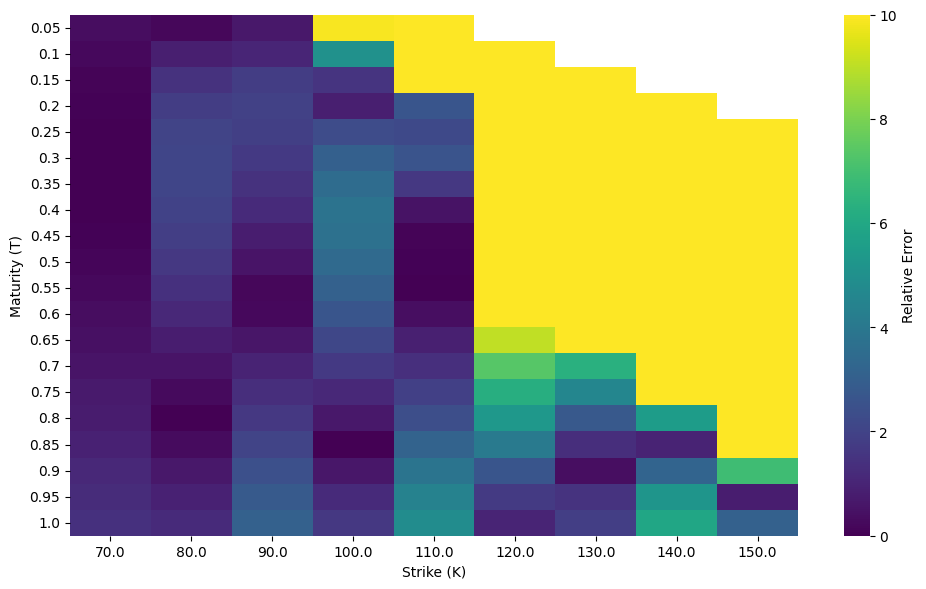

In [9]:
df["rel_error"] = np.abs(df["Price"] - df["price_model"]) / df["Price"] *100
df["T"] = df["T"].round(2)
error_pivot = df.pivot_table(index="T",  columns="K", values="rel_error", aggfunc="mean")

plt.figure(figsize=(10, 6))
sns.heatmap(error_pivot, cmap="viridis", cbar_kws={'label': 'Relative Error'}, vmin=0,  vmax=10 , annot=False)

plt.xlabel("Strike (K)")
plt.ylabel("Maturity (T)")

plt.tight_layout()
plt.show()